## Goal

We need to split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

 

We need to accomplish the following in this assignment:

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, we can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after the modifications.

## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('universal_tagset')


import warnings
warnings.filterwarnings('ignore')
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



sns.set_style(style='dark')
sns.set_context("notebook")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/akumar/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

## Configuration

In [4]:
random_state=100
small_sample = False

## Train Test split

In [5]:
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=random_state)

In [6]:
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95949

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['One',
 'bright',
 'sign',
 'is',
 'that',
 'a',
 'growing',
 'number',
 'of',
 'women']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12106


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print(T)

{'VERB', 'ADV', 'PRON', 'PRT', 'DET', 'NUM', 'CONJ', 'X', 'ADJ', '.', 'NOUN', 'ADP'}


## Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag=train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

In [13]:
# Example will
print("\n", "have")
print(word_given_tag('have', 'PRON'))
print(word_given_tag('have', 'NOUN'))
print(word_given_tag('have', 'VERB'))


 have
(0, 2610)
(0, 27539)
(305, 12919)


## Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags) - 1):
        if tags[index] == t1 and tags[index + 1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# examples
print(t2_given_t1(t2='VERB', t1='NOUN'))
print(t2_given_t1('NOUN', 'ADJ'))

(4047, 27539)
(4279, 6105)


In [16]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('ADJ', '.'))

(2481, 11149)
(989, 11149)
(487, 11149)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0] / t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[1.68743715e-01, 8.20496976e-02, 3.59160937e-02, 3.14265825e-02,
        1.33292049e-01, 2.24475581e-02, 5.18616010e-03, 2.18437955e-01,
        6.56397566e-02, 3.42905782e-02, 1.11386329e-01, 9.11835283e-02],
       [3.44540626e-01, 7.72303566e-02, 1.56458057e-02, 1.43142473e-02,
        6.99067935e-02, 3.16244997e-02, 6.99067907e-03, 2.33022645e-02,
        1.30159780e-01, 1.35153130e-01, 3.16244997e-02, 1.19507320e-01],
       [4.84291196e-01, 3.40996161e-02, 7.66283507e-03, 1.22605367e-02,
        9.19540226e-03, 7.27969361e-03, 4.98084305e-03, 9.27203074e-02,
        7.20306486e-02, 4.06130254e-02, 2.11494252e-01, 2.33716480e-02],
       [4.05183733e-01, 1.01706041e-02, 1.77165363e-02, 1.96850393e-03,
        1.01049870e-01, 5.61023615e-02, 2.29658792e-03, 1.31233595e-02,
        8.36614147e-02, 4.36351709e-02, 2.45734915e-01, 1.93569548e-02],
       [4.03943248e-02, 1.26232272e-02, 3.72685748e-03, 2.40442416e-04,
        5.77061810e-03, 2.16398165e-02, 4.80884832e-04, 4.53

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [20]:
tags_df

,VERB,ADV,PRON,PRT,DET,NUM,CONJ,X,ADJ,.,NOUN,ADP
VERB,0.1687,0.0820,0.0359,0.0314,0.1333,0.0224,0.0052,0.2184,0.0656,0.0343,0.1114,0.0912
ADV,0.3445,0.0772,0.0156,0.0143,0.0699,0.0316,0.0070,0.0233,0.1302,0.1352,0.0316,0.1195
PRON,0.4843,0.0341,0.0077,0.0123,0.0092,0.0073,0.0050,0.0927,0.0720,0.0406,0.2115,0.0234
PRT,0.4052,0.0102,0.0177,0.0020,0.1010,0.0561,0.0023,0.0131,0.0837,0.0436,0.2457,0.0194
DET,0.0404,0.0126,0.0037,0.0002,0.0058,0.0216,0.0005,0.0453,0.2050,0.0179,0.6373,0.0096
NUM,0.0169,0.0027,0.0015,0.0261,0.0039,0.1842,0.0131,0.2118,0.0336,0.1188,0.3523,0.0351
CONJ,0.1553,0.0538,0.0584,0.0037,0.1187,0.0422,0.0005,0.0088,0.1187,0.0357,0.3505,0.0538
X,0.2046,0.0254,0.0557,0.1849,0.0552,0.0029,0.0103,0.0744,0.0165,0.1628,0.0624,0.1449
ADJ,0.0118,0.0049,0.0005,0.0102,0.0049,0.0208,0.0161,0.0203,0.0672,0.0639,0.7009,0.0786
.,0.0887,0.0523,0.0652,0.0025,0.1736,0.0814,0.0580,0.0269,0.0437,0.0929,0.2225,0.0922


In [21]:
tags_df.loc['.', :]

VERB   0.0887
ADV    0.0523
PRON   0.0652
PRT    0.0025
DET    0.1736
NUM    0.0814
CONJ   0.0580
X      0.0269
ADJ    0.0437
.      0.0929
NOUN   0.2225
ADP    0.0922
Name: ., dtype: float32

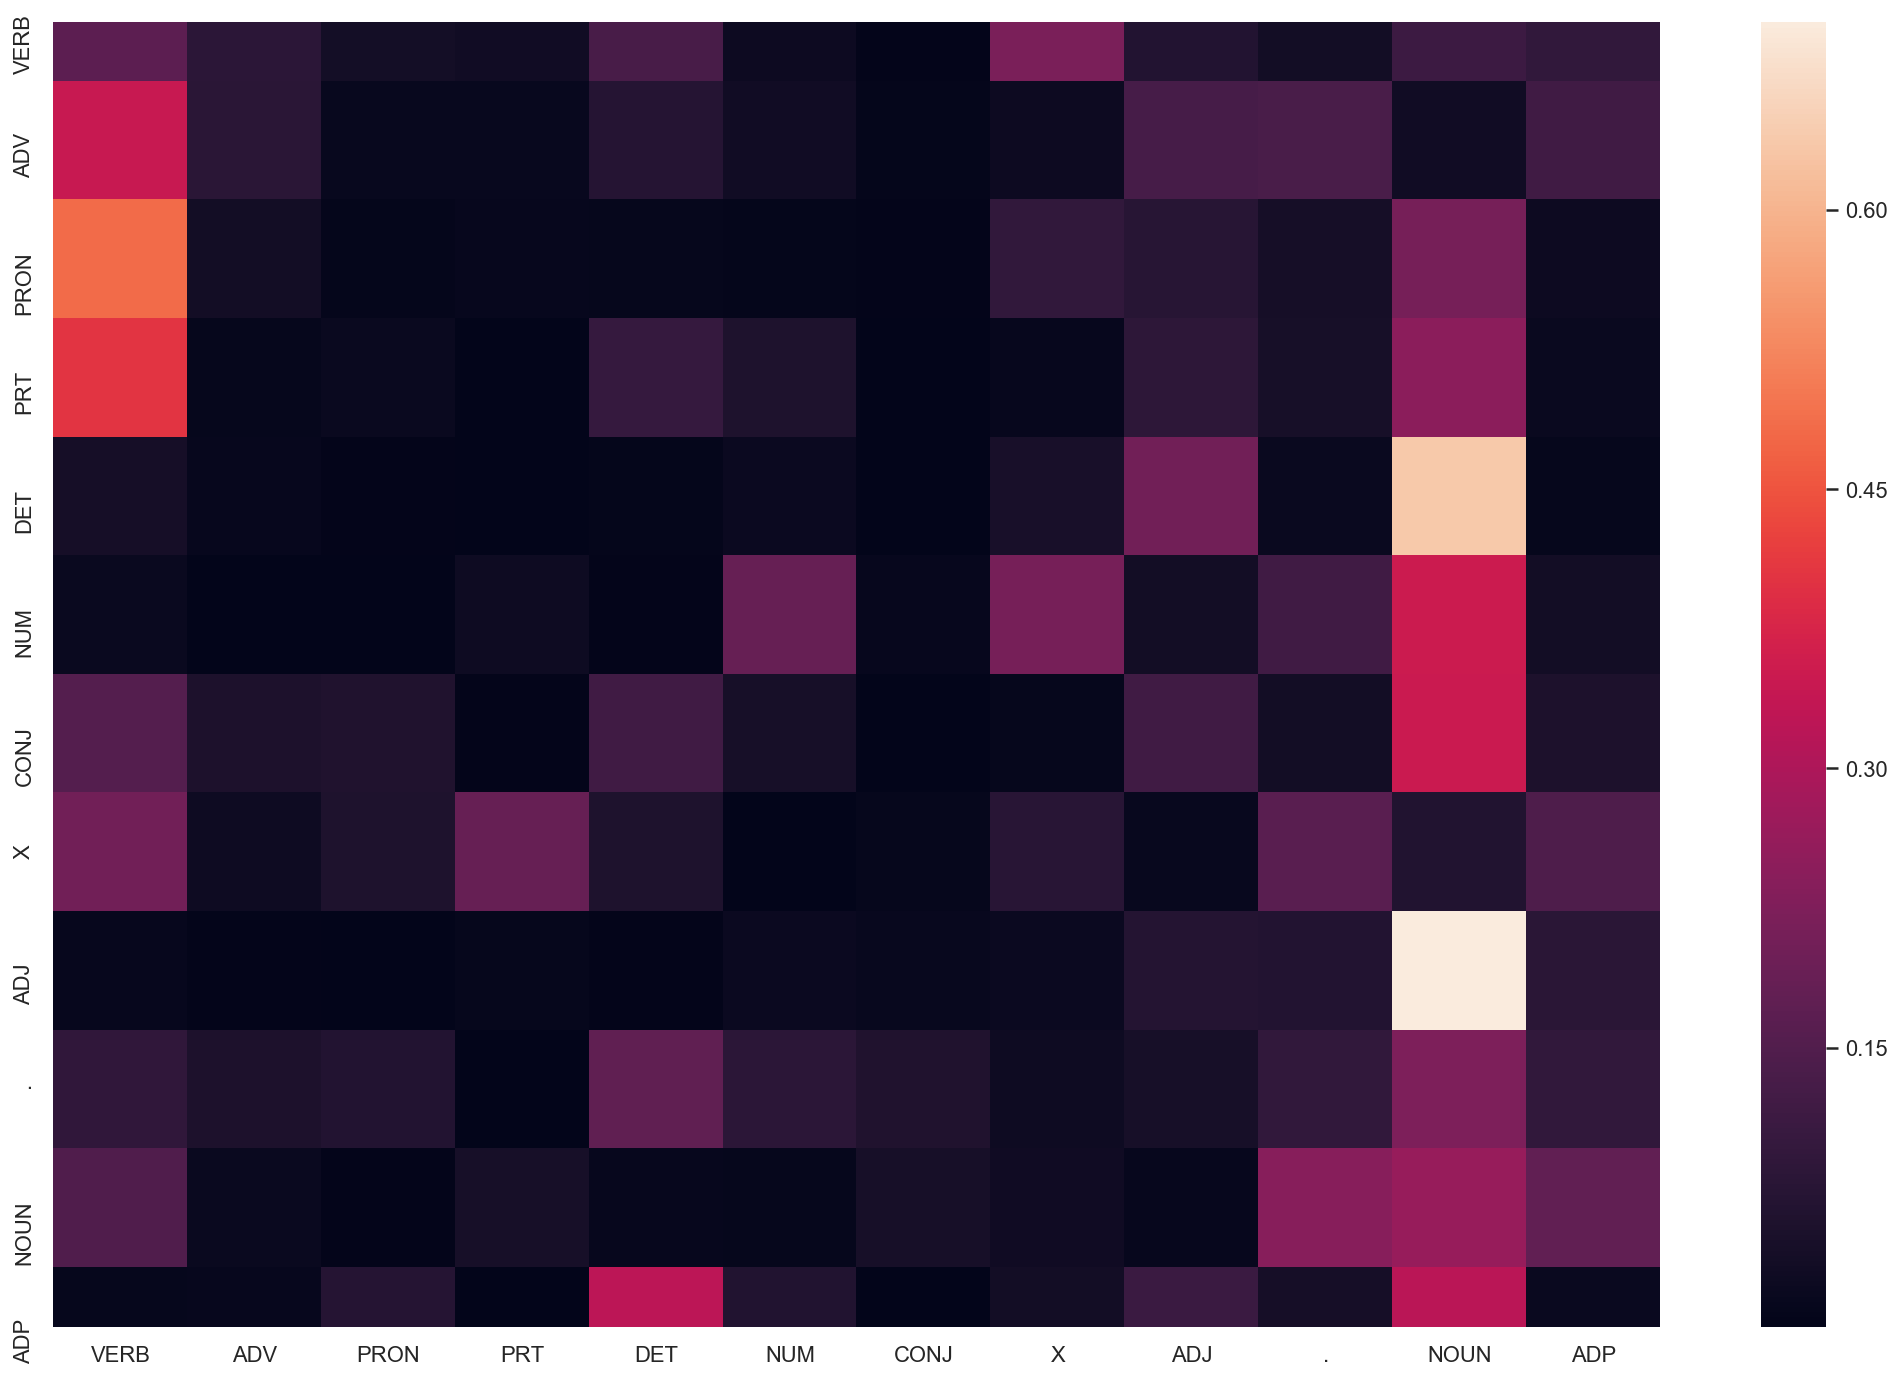

In [22]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


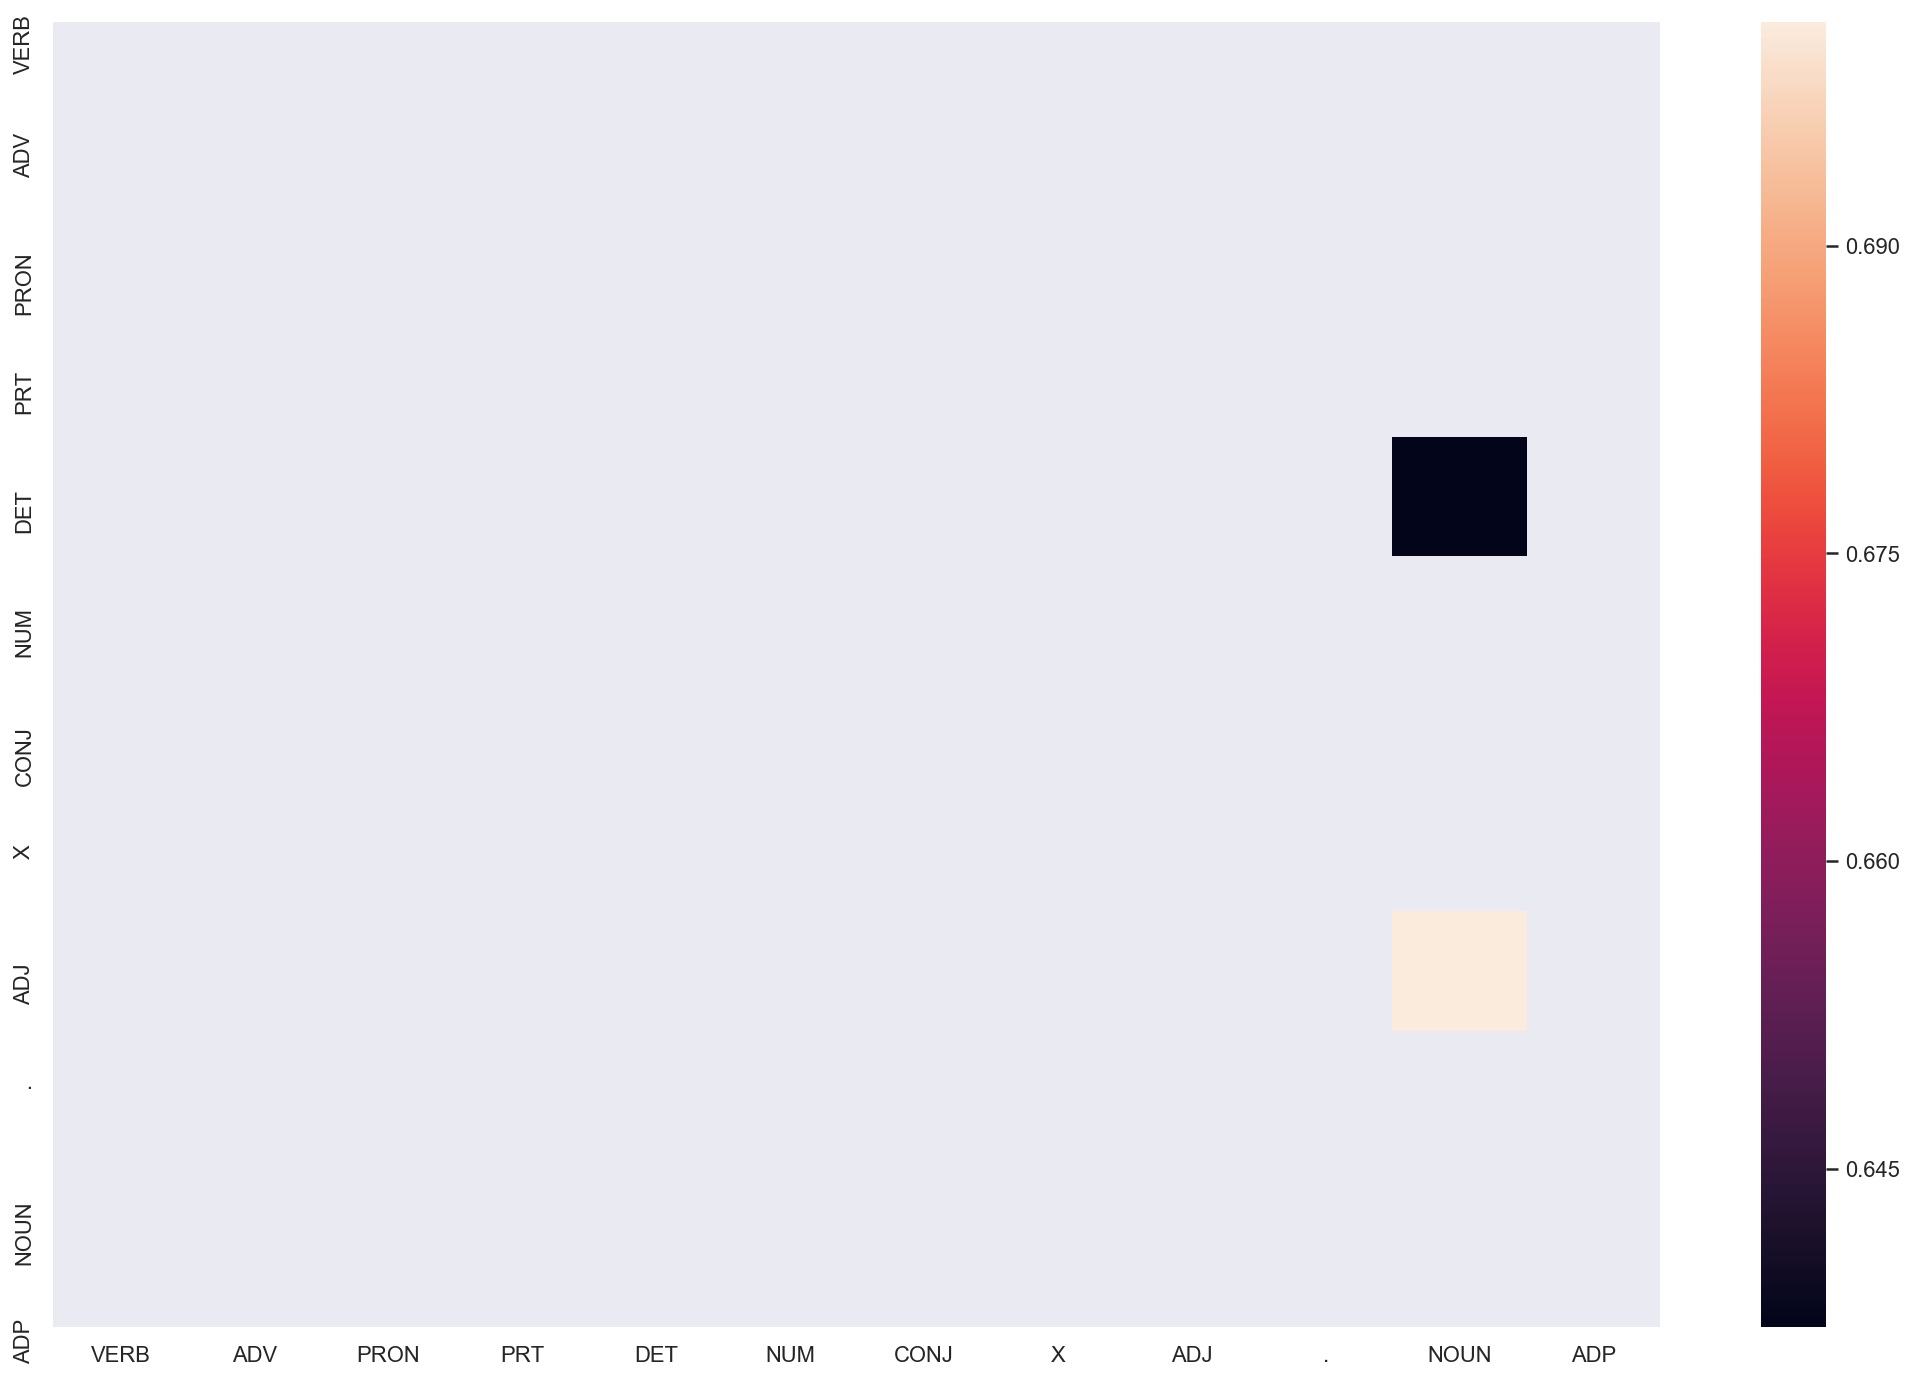

In [23]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df > 0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [24]:
# This method takes a tagger and runs against the validation set and returns the metrics like accuracy, number of incorrect words.

def run_and_get_accuracies(tagger, sample=small_sample):
    # list of sents
    # list of tagged words
    if sample:
        random.seed(random_state)
        rndom = [random.randint(1, len(test_set)) for x in range(5)]
        test_run = [test_set[i] for i in rndom]
    else:
        test_run = test_set

    test_run_base = [tup for sent in test_run for tup in sent]
    # list of untagged words
    test_tagged_words = [tup[0] for sent in test_run for tup in sent]

    print("Sample Sentences \n")
    pprint.pprint(test_run[:4])
    start = time.time()
    tagged_seq = tagger(test_tagged_words)
    end = time.time()
    difference = end - start
    print("\nTime taken in (seconds): ", difference)
    check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
    accuracy = len(check) / len(tagged_seq)
    print("\naccuracy: ", accuracy)

    incorrect_tagged_cases = [
        j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]
    ]

    print("\nIncorrect tagged \n")
    pprint.pprint(incorrect_tagged_cases[:5])
    metrics_dict = {
        'tagger': tagger.__name__,
        'accuracy': accuracy * 100,
        'incorrect_tagged': len(incorrect_tagged_cases)
    }
    records = []
    records.append(metrics_dict)
    return pd.DataFrame.from_records(records)

### Build the vanilla Viterbi based POS tagger

In [25]:
# Viterbi Heuristic
def viterbi_vanilla(words, train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [26]:
tagger_metrics = run_and_get_accuracies(viterbi_vanilla)
tagger_metrics

Sample Sentences 

[[('Investors', 'NOUN'),
  ('took', 'VERB'),
  ('advantage', 'NOUN'),
  ('of', 'ADP'),
  ('Tuesday', 'NOUN'),
  ("'s", 'PRT'),
  ('stock', 'NOUN'),
  ('rally', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('book', 'VERB'),
  ('some', 'DET'),
  ('profits', 'NOUN'),
  ('yesterday', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('leaving', 'VERB'),
  ('stocks', 'ADV'),
  ('up', 'ADP'),
  ('fractionally', 'ADV'),
  ('.', '.')],
 [('Buying', 'VERB'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('most', 'ADJ'),
  ('part', 'NOUN'),
  ('carried', 'VERB'),
  ('over', 'PRT'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('previous', 'ADJ'),
  ('session', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('traders', 'NOUN'),
  ('apparently', 'ADV'),
  ('ignored', 'VERB'),
  ('reports', 'NOUN'),
  ('that', 'ADP'),
  ('a', 'DET'),
  ('Chilean', 'ADJ'),
  ('mine', 'ADJ'),
  ('strike', 'NOUN'),
  ('may', 'VERB'),
  ('have', 'VERB'),
  ('ended', 'VERB'),
  ('almost', 'ADV'),
  ('before', 'ADP'),
  ('it', '

,tagger,accuracy,incorrect_tagged
0,viterbi_vanilla,91.4745,403


### Solve the problem of unknown words

We will be following the approaches mentioned in the paper https://cl.lingfil.uu.se/~nivre/statmet/haulrich.pdf

In [27]:
# Mapping the tags to their frequencies and probabilities 

from collections import Counter

tags_with_frequency = Counter([pair[1] for pair in train_tagged_words])
tags_count = sum(tags_with_frequency.values())
print('Total tags: ', tags_count)

for k in tags_with_frequency.keys():
    tags_with_frequency[k] = tags_with_frequency[k] / tags_count

tags_with_frequency

Total tags:  95949


Counter({'NUM': 0.035081136853953664,
         'ADJ': 0.06362755213707282,
         'NOUN': 0.2870170611470677,
         'VERB': 0.13464444652888513,
         'ADP': 0.09831264525946075,
         'DET': 0.08669188839904532,
         'ADV': 0.03130829920061699,
         '.': 0.11619714640069204,
         'X': 0.06567030401567499,
         'PRON': 0.027201951036488134,
         'PRT': 0.03176687615295626,
         'CONJ': 0.022480692868086172})

### Most probable POS-tag
Looking at the whole training corpus we can find the most frequent POS-tagand assume that unknown words always have this POS-tag. This implies that for all unknown words we will select the tag with highest frequency in the corpus.

In [28]:
def viterbi_modified_most_probable_pos_tag(words,
                                           train_bag=train_tagged_words,verbose = True):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []
    tag_with_max_frequency = max(tags_with_frequency,
                                 key=tags_with_frequency.get)
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        if pmax == 0:
            # Taking the most probable tag
            state_max = tag_with_max_frequency
            unknown_words.append({"word": word, "mapped_to": state_max})
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    if verbose:
        print("\nUnknown words:")
        display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [29]:
df = run_and_get_accuracies(viterbi_modified_most_probable_pos_tag)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Investors', 'NOUN'),
  ('took', 'VERB'),
  ('advantage', 'NOUN'),
  ('of', 'ADP'),
  ('Tuesday', 'NOUN'),
  ("'s", 'PRT'),
  ('stock', 'NOUN'),
  ('rally', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('book', 'VERB'),
  ('some', 'DET'),
  ('profits', 'NOUN'),
  ('yesterday', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('leaving', 'VERB'),
  ('stocks', 'ADV'),
  ('up', 'ADP'),
  ('fractionally', 'ADV'),
  ('.', '.')],
 [('Buying', 'VERB'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('most', 'ADJ'),
  ('part', 'NOUN'),
  ('carried', 'VERB'),
  ('over', 'PRT'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('previous', 'ADJ'),
  ('session', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('traders', 'NOUN'),
  ('apparently', 'ADV'),
  ('ignored', 'VERB'),
  ('reports', 'NOUN'),
  ('that', 'ADP'),
  ('a', 'DET'),
  ('Chilean', 'ADJ'),
  ('mine', 'ADJ'),
  ('strike', 'NOUN'),
  ('may', 'VERB'),
  ('have', 'VERB'),
  ('ended', 'VERB'),
  ('almost', 'ADV'),
  ('before', 'ADP'),
  ('it', '

,word,mapped_to
0,ignored,NOUN
1,Preston,NOUN
2,Birmingham,NOUN
3,Ala,NOUN
4,clamped,NOUN
5,ankle,NOUN
6,third-largest,NOUN
7,fifth-largest,NOUN
8,Z.,NOUN
9,Wick,NOUN



Time taken in (seconds):  941.79123711586

accuracy:  0.9348423947535435

Incorrect tagged 

[(('book', 'NOUN'), ('book', 'VERB')),
 (('stocks', 'NOUN'), ('stocks', 'ADV')),
 (('up', 'PRT'), ('up', 'ADP')),
 (('over', 'ADP'), ('over', 'PRT')),
 (('ignored', 'NOUN'), ('ignored', 'VERB'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_most_probable_pos_tag,93.4842,308


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [30]:
def compare_tagger(sentence, tagger1, tagger2):
    words = word_tokenize(sentence)
    tagger1_result = tagger1(words)
    tagger2_result = tagger2(words, verbose=False)

    difference = [{
        'word': i[0],
        tagger1.__name__: i[1],
        tagger2.__name__: j[1]
    } for i, j in zip(tagger1_result, tagger2_result) if i != j]
    return pd.DataFrame.from_records(difference)

In [31]:
# Sentences from the given text file
sentences = [
    "Android is a mobile operating system developed by Google.",
    "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
    "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
    "NASA invited social media users to experience the launch of ICESAT-2 Satellite."
]

In [32]:
for sentence in sentences:
    print("\nFor sentence: ",sentence)
    display(compare_tagger(sentence,viterbi_vanilla,viterbi_modified_most_probable_pos_tag))


For sentence:  Android is a mobile operating system developed by Google.


,word,viterbi_vanilla,viterbi_modified_most_probable_pos_tag
0,Android,VERB,NOUN
1,Google,VERB,NOUN



For sentence:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.


,word,viterbi_vanilla,viterbi_modified_most_probable_pos_tag
0,Google,VERB,NOUN
1,Twitter,VERB,NOUN
2,2015,VERB,NOUN
3,Google,VERB,NOUN
4,Twitter,VERB,NOUN
5,firehose,VERB,NOUN



For sentence:  The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.


,word,viterbi_vanilla,viterbi_modified_most_probable_pos_tag
0,2018,VERB,NOUN
1,FIFA,VERB,NOUN
2,Cup,VERB,NOUN
3,21st,VERB,NOUN
4,FIFA,VERB,NOUN
5,Cup,VERB,NOUN
6,tournament,VERB,NOUN
7,contested,VERB,NOUN



For sentence:  NASA invited social media users to experience the launch of ICESAT-2 Satellite.


,word,viterbi_vanilla,viterbi_modified_most_probable_pos_tag
0,NASA,VERB,NOUN
1,invited,VERB,NOUN
2,ICESAT-2,VERB,NOUN
3,Satellite,VERB,NOUN


## Overall POS distribution

Here we give weight to probabilities of each tag. 

In [33]:
def viterbi_modified_overall_pos_distribution(words,
                                              train_bag=train_tagged_words,
                                              verbose=True):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        p_trans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            p_trans.append(tags_with_frequency.get(tag) * transition_p)

        pmax = max(p)
        if pmax == 0:
            pmax = max(p_trans)
            state_max = T[p_trans.index(pmax)]
            unknown_words.append({"word": word, "mapped_to": state_max})
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]

        state.append(state_max)
    if verbose:
        print("\nUnknown words:")
        display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [34]:
df = run_and_get_accuracies(viterbi_modified_overall_pos_distribution)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Investors', 'NOUN'),
  ('took', 'VERB'),
  ('advantage', 'NOUN'),
  ('of', 'ADP'),
  ('Tuesday', 'NOUN'),
  ("'s", 'PRT'),
  ('stock', 'NOUN'),
  ('rally', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('book', 'VERB'),
  ('some', 'DET'),
  ('profits', 'NOUN'),
  ('yesterday', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('leaving', 'VERB'),
  ('stocks', 'ADV'),
  ('up', 'ADP'),
  ('fractionally', 'ADV'),
  ('.', '.')],
 [('Buying', 'VERB'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('most', 'ADJ'),
  ('part', 'NOUN'),
  ('carried', 'VERB'),
  ('over', 'PRT'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('previous', 'ADJ'),
  ('session', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('traders', 'NOUN'),
  ('apparently', 'ADV'),
  ('ignored', 'VERB'),
  ('reports', 'NOUN'),
  ('that', 'ADP'),
  ('a', 'DET'),
  ('Chilean', 'ADJ'),
  ('mine', 'ADJ'),
  ('strike', 'NOUN'),
  ('may', 'VERB'),
  ('have', 'VERB'),
  ('ended', 'VERB'),
  ('almost', 'ADV'),
  ('before', 'ADP'),
  ('it', '

,word,mapped_to
0,ignored,VERB
1,Preston,NOUN
2,Birmingham,NOUN
3,Ala,NOUN
4,clamped,NOUN
5,ankle,VERB
6,third-largest,NOUN
7,fifth-largest,NOUN
8,Z.,NOUN
9,Wick,NOUN



Time taken in (seconds):  1099.764711856842

accuracy:  0.9373810027501587

Incorrect tagged 

[(('book', 'NOUN'), ('book', 'VERB')),
 (('stocks', 'NOUN'), ('stocks', 'ADV')),
 (('up', 'PRT'), ('up', 'ADP')),
 (('over', 'ADP'), ('over', 'PRT')),
 (('mine', 'NOUN'), ('mine', 'ADJ'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_overall_pos_distribution,93.7381,296


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [35]:
for sentence in sentences:
    print("\nFor sentence: ",sentence)
    display(compare_tagger(sentence,viterbi_vanilla,viterbi_modified_overall_pos_distribution))


For sentence:  Android is a mobile operating system developed by Google.


,word,viterbi_vanilla,viterbi_modified_overall_pos_distribution
0,Android,VERB,NOUN
1,Google,VERB,NOUN



For sentence:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.


,word,viterbi_vanilla,viterbi_modified_overall_pos_distribution
0,Google,VERB,NOUN
1,Twitter,VERB,NOUN
2,2015,VERB,NOUN
3,Google,VERB,NOUN
4,Twitter,VERB,NOUN
5,firehose,VERB,NOUN



For sentence:  The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.


,word,viterbi_vanilla,viterbi_modified_overall_pos_distribution
0,2018,VERB,NOUN
1,FIFA,VERB,NOUN
2,Cup,VERB,NOUN
3,21st,VERB,NOUN
4,FIFA,VERB,NOUN
5,Cup,VERB,NOUN
6,tournament,VERB,NOUN
7,contested,VERB,NOUN



For sentence:  NASA invited social media users to experience the launch of ICESAT-2 Satellite.


,word,viterbi_vanilla,viterbi_modified_overall_pos_distribution
0,NASA,VERB,NOUN
1,invited,VERB,NOUN
2,ICESAT-2,VERB,NOUN
3,Satellite,VERB,NOUN


## Regex Based Tagger

Here we will use regex based tagger as the fall back to identify the tags of the unknown words.

In [36]:
# From https://www.nltk.org/book/ch05.html

patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb 
    (r'.*able$', 'ADJ'),               # adjective 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.*est$', 'ADJ'),
    (r'.*lly$', 'ADV'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ould$', 'X'),                # modals
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                 # nouns
]
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [37]:
def viterbi_modified_regex(words, train_bag=train_tagged_words, verbose=True):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []

    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        if pmax == 0:
            state_max = rule_based_tagger.tag([word])[0][1]
            unknown_words.append({"word": word, "mapped_to": state_max})
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    if verbose:
        print("\nUnknown words:")
        display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [38]:
df = run_and_get_accuracies(viterbi_modified_regex)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Investors', 'NOUN'),
  ('took', 'VERB'),
  ('advantage', 'NOUN'),
  ('of', 'ADP'),
  ('Tuesday', 'NOUN'),
  ("'s", 'PRT'),
  ('stock', 'NOUN'),
  ('rally', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('book', 'VERB'),
  ('some', 'DET'),
  ('profits', 'NOUN'),
  ('yesterday', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('leaving', 'VERB'),
  ('stocks', 'ADV'),
  ('up', 'ADP'),
  ('fractionally', 'ADV'),
  ('.', '.')],
 [('Buying', 'VERB'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('most', 'ADJ'),
  ('part', 'NOUN'),
  ('carried', 'VERB'),
  ('over', 'PRT'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('previous', 'ADJ'),
  ('session', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('traders', 'NOUN'),
  ('apparently', 'ADV'),
  ('ignored', 'VERB'),
  ('reports', 'NOUN'),
  ('that', 'ADP'),
  ('a', 'DET'),
  ('Chilean', 'ADJ'),
  ('mine', 'ADJ'),
  ('strike', 'NOUN'),
  ('may', 'VERB'),
  ('have', 'VERB'),
  ('ended', 'VERB'),
  ('almost', 'ADV'),
  ('before', 'ADP'),
  ('it', '

,word,mapped_to
0,ignored,VERB
1,Preston,NOUN
2,Birmingham,NOUN
3,Ala,NOUN
4,clamped,VERB
5,ankle,NOUN
6,third-largest,ADJ
7,fifth-largest,ADJ
8,Z.,NOUN
9,Wick,NOUN



Time taken in (seconds):  1034.2086670398712

accuracy:  0.950920245398773

Incorrect tagged 

[(('book', 'NOUN'), ('book', 'VERB')),
 (('stocks', 'NOUN'), ('stocks', 'ADV')),
 (('up', 'PRT'), ('up', 'ADP')),
 (('over', 'ADP'), ('over', 'PRT')),
 (('mine', 'NOUN'), ('mine', 'ADJ'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_regex,95.0920,232


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [39]:
for sentence in sentences:
    print("\nFor sentence: ",sentence)
    display(compare_tagger(sentence,viterbi_vanilla,viterbi_modified_regex))


For sentence:  Android is a mobile operating system developed by Google.


,word,viterbi_vanilla,viterbi_modified_regex
0,Android,VERB,NOUN
1,Google,VERB,NOUN



For sentence:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.


,word,viterbi_vanilla,viterbi_modified_regex
0,Google,VERB,NOUN
1,Twitter,VERB,NOUN
2,2015,VERB,NUM
3,Google,VERB,NOUN
4,Twitter,VERB,NOUN
5,firehose,VERB,NOUN



For sentence:  The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.


,word,viterbi_vanilla,viterbi_modified_regex
0,2018,VERB,NUM
1,FIFA,VERB,NOUN
2,Cup,VERB,NOUN
3,21st,VERB,NOUN
4,FIFA,VERB,NOUN
5,Cup,VERB,NOUN
6,tournament,VERB,NOUN



For sentence:  NASA invited social media users to experience the launch of ICESAT-2 Satellite.


,word,viterbi_vanilla,viterbi_modified_regex
0,NASA,VERB,NOUN
1,ICESAT-2,VERB,NOUN
2,Satellite,VERB,NOUN


We can see that words like `Android`, `Google`, `Twitter`, `FIFA`, `contested` etc which were incorrectly tagged by the vanilla Viterbi tagger as `NUM` are correctly tagged by the modified regex tagger.

## Mapping words to pseudo words

Here we are following the approach suggested in the paper http://www.cs.columbia.edu/~mcollins/hmms-spring2013.pdf. We will map the words to a class of pseudo words so that the unknown words can also be mapped to these pseudo words and then we will use the probability distribution for these pseudo words to figure the tag for the unknown word.

|Word class| Example |Intuition|
|----------|---------|---------|
|twoDigitNum|90|Two digit year|
|fourDigitNum|1990|Four digit year|
|containsDigitAndAlpha|A8956-67|Product code|
|containsDigitAndDash|09-96|Date|
|containsDigitAndSlash|11/9/89|Date|
|containsDigitAndComma|23,000.00|Monetary amount|
|containsDigitAndPeriod|1.00|Monetary amount,percentage|
|othernum|456789|Other number|
|allCaps|BBN|Organization|
|capPeriod|M.|Person name initial|
|initCap|Sally|Capitalized word|
|lowercase|can|Uncapitalized word|
|other|,Punctuation |marks ,    all   otherwords|

In [40]:
# Mapping words to a class of pseudo words so that if a new word is seen, 
# it can also be mapped to one of these pseudo classes.
import re
def map_pseudo_word(word):
    pseudo_word = ""
    if word.isdigit() and len(word)==2:
        pseudo_word = "twoDigitNum"
    elif word.isdigit() and len(word)==4:
        pseudo_word = "fourDigitNum"
    elif re.match("^[A-Za-z]+[0-9]+\-.*$", word):
        pseudo_word = "containsDigitAndAlpha"
    elif re.match("^[0-9]+\-[0-9]+$", word):
        pseudo_word = "containsDigitAndDash"
    elif re.match("^[0-9]+\\\[0-9]+\\\[0-9]+$", word) or re.match("^[0-9]+/[0-9]+/[0-9]+$", word):
        pseudo_word = "containsDigitAndSlash"
    elif re.match("^[+-]?[0-9]+,[0-9]+.*$", word):
        pseudo_word = "containsDigitAndComma"
    elif re.match("^[+-]?[0-9]+\.[0-9]+$", word):
        pseudo_word = "containsDigitAndPeriod"
    elif re.match("^[0-9]+$", word):
        pseudo_word = "othernum"
    elif re.match("^[A-Z]+$", word):
        pseudo_word = "allCaps"
    elif re.match("^[A-Z]+\.$", word):
        pseudo_word = "capPeriod"
    elif word.istitle():
        pseudo_word = "initCap"
    elif re.match("^[a-z]+$", word):
        pseudo_word = "lowercase"
    else:
        pseudo_word = "other"
    return pseudo_word


In [41]:
from collections import Counter
from collections import defaultdict
pseudo_words_with_tags = [(map_pseudo_word(pair[0]), pair[1])
                          for pair in train_tagged_words]
dd = defaultdict(list)
for t in pseudo_words_with_tags:
    dd[t[0]].append(t[1])

for k in dd.keys():
    d = Counter(dd[k])
    tags_count = sum(d.values())
    for tk in d.keys():
        d[tk] = d[tk] / tags_count
    dd[k] = d

pprint.pprint(dd)

defaultdict(<class 'list'>,
            {'allCaps': Counter({'NOUN': 0.6415384615384615,
                                 'PRON': 0.16307692307692306,
                                 'DET': 0.15692307692307692,
                                 'VERB': 0.015384615384615385,
                                 'ADJ': 0.007692307692307693,
                                 'NUM': 0.006153846153846154,
                                 'ADP': 0.004615384615384616,
                                 'ADV': 0.0015384615384615385,
                                 'X': 0.0015384615384615385,
                                 'PRT': 0.0015384615384615385}),
             'capPeriod': Counter({'NOUN': 1.0}),
             'containsDigitAndComma': Counter({'NUM': 0.9900990099009901,
                                               'ADJ': 0.009900990099009901}),
             'containsDigitAndDash': Counter({'NUM': 1.0}),
             'containsDigitAndPeriod': Counter({'NUM': 1.0}),
             'fourDigitNum

In [42]:
def viterbi_modified_pseudo_mapped_words(words,
                                         train_bag=train_tagged_words,
                                         verbose=True):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        p_trans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            p_trans.append(
                dd.get(map_pseudo_word(word)).get(tag, 0) * transition_p)

        pmax = max(p)
        if pmax == 0:
            pmax = max(p_trans)
            state_max = T[p_trans.index(pmax)]
            unknown_words.append({"word": word, "mapped_to": state_max})
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    if verbose:
        print("\nUnknown words:")
        display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [43]:
df = run_and_get_accuracies(viterbi_modified_pseudo_mapped_words)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Investors', 'NOUN'),
  ('took', 'VERB'),
  ('advantage', 'NOUN'),
  ('of', 'ADP'),
  ('Tuesday', 'NOUN'),
  ("'s", 'PRT'),
  ('stock', 'NOUN'),
  ('rally', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('book', 'VERB'),
  ('some', 'DET'),
  ('profits', 'NOUN'),
  ('yesterday', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('leaving', 'VERB'),
  ('stocks', 'ADV'),
  ('up', 'ADP'),
  ('fractionally', 'ADV'),
  ('.', '.')],
 [('Buying', 'VERB'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('most', 'ADJ'),
  ('part', 'NOUN'),
  ('carried', 'VERB'),
  ('over', 'PRT'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('previous', 'ADJ'),
  ('session', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('traders', 'NOUN'),
  ('apparently', 'ADV'),
  ('ignored', 'VERB'),
  ('reports', 'NOUN'),
  ('that', 'ADP'),
  ('a', 'DET'),
  ('Chilean', 'ADJ'),
  ('mine', 'ADJ'),
  ('strike', 'NOUN'),
  ('may', 'VERB'),
  ('have', 'VERB'),
  ('ended', 'VERB'),
  ('almost', 'ADV'),
  ('before', 'ADP'),
  ('it', '

,word,mapped_to
0,ignored,VERB
1,Preston,NOUN
2,Birmingham,NOUN
3,Ala,NOUN
4,clamped,VERB
5,ankle,VERB
6,third-largest,NOUN
7,fifth-largest,NOUN
8,Z.,NOUN
9,Wick,NOUN



Time taken in (seconds):  1242.9010729789734

accuracy:  0.9458430294055427

Incorrect tagged 

[(('book', 'NOUN'), ('book', 'VERB')),
 (('stocks', 'NOUN'), ('stocks', 'ADV')),
 (('up', 'PRT'), ('up', 'ADP')),
 (('over', 'ADP'), ('over', 'PRT')),
 (('mine', 'NOUN'), ('mine', 'ADJ'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_pseudo_mapped_words,94.5843,256


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [44]:
for sentence in sentences:
    print("\nFor sentence: ",sentence)
    display(compare_tagger(sentence,viterbi_vanilla,viterbi_modified_pseudo_mapped_words))


For sentence:  Android is a mobile operating system developed by Google.


,word,viterbi_vanilla,viterbi_modified_pseudo_mapped_words
0,Android,VERB,NOUN
1,Google,VERB,NOUN



For sentence:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.


,word,viterbi_vanilla,viterbi_modified_pseudo_mapped_words
0,Google,VERB,NOUN
1,Twitter,VERB,NOUN
2,2015,VERB,NUM
3,Google,VERB,NOUN
4,Twitter,VERB,NOUN



For sentence:  The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.


,word,viterbi_vanilla,viterbi_modified_pseudo_mapped_words
0,2018,VERB,NUM
1,FIFA,VERB,NOUN
2,Cup,VERB,NOUN
3,21st,VERB,NOUN
4,FIFA,VERB,NOUN
5,Cup,VERB,NOUN
6,tournament,VERB,NOUN
7,contested,VERB,NOUN



For sentence:  NASA invited social media users to experience the launch of ICESAT-2 Satellite.


,word,viterbi_vanilla,viterbi_modified_pseudo_mapped_words
0,NASA,VERB,NOUN
1,invited,VERB,NOUN
2,ICESAT-2,VERB,.
3,Satellite,VERB,NOUN


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [45]:
tagger_metrics = tagger_metrics.sort_values(by='accuracy', ascending=False)
tagger_metrics


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_regex,95.0920,232
0,viterbi_modified_pseudo_mapped_words,94.5843,256
0,viterbi_modified_overall_pos_distribution,93.7381,296
0,viterbi_modified_most_probable_pos_tag,93.4842,308
0,viterbi_vanilla,91.4745,403


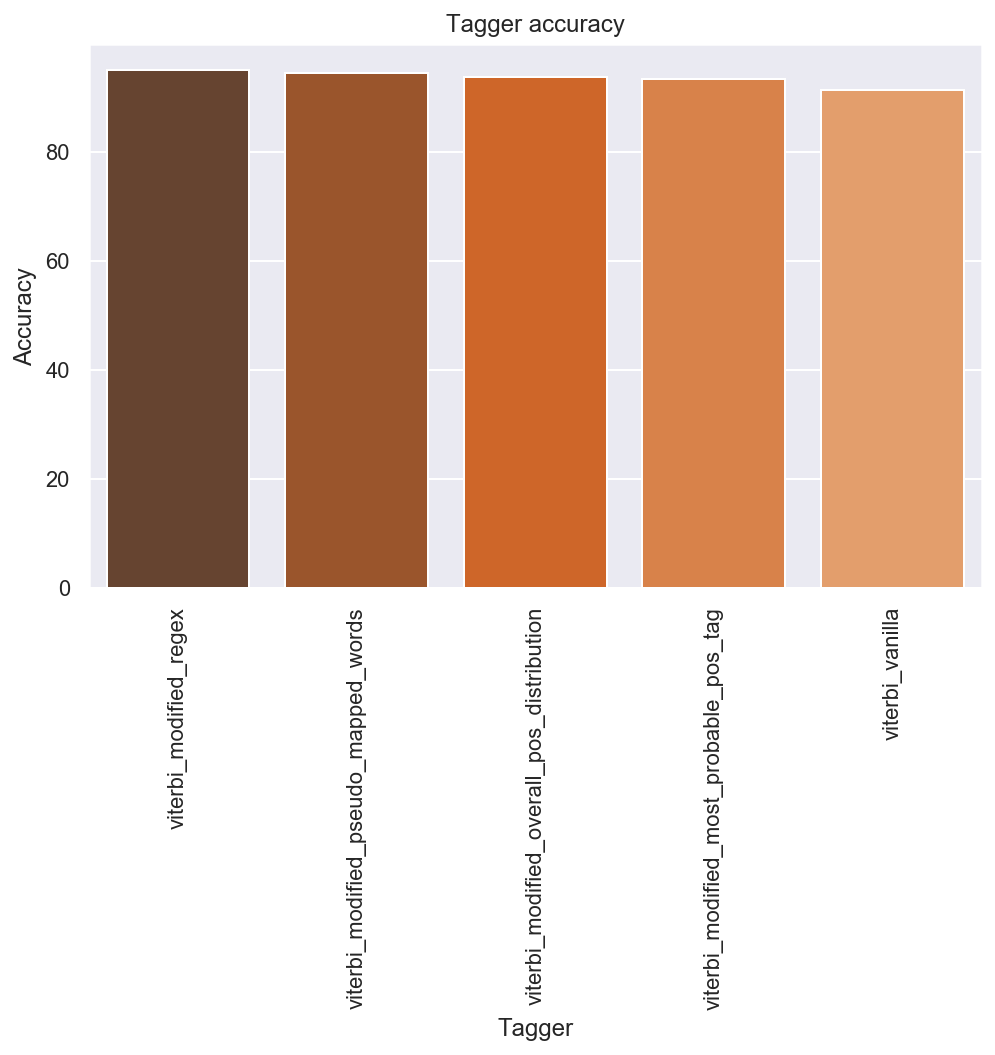

In [46]:
sns.set(rc={'figure.figsize': (8, 5)})
sns.barplot(tagger_metrics['tagger'],
            tagger_metrics['accuracy'],
            palette='Oranges_d')
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Tagger accuracy")
plt.xlabel("Tagger")
plt.ylabel("Accuracy")
plt.show()